In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from phik.report import plot_correlation_matrix
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import catboost
from catboost import Pool, cv, CatBoostClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
import dill as pickle

pd.options.display.float_format = '{:.3f}'.format

Здравствуйте! Я написал краткое предисловие, чтобы в работе было проще ориентироваться.

Логика работы следующая:

1. Сначала проводится первичный анализ данных;
2. Затем на необработанных данных обучается дефолтный CatboostClassifier(), результат auc_test = 0.923;
3. Затем обучается catboost.cv, средний auc на валидационных фолдах 0.939, auc усреднённой модели 0.922;
4. Затем на предобработанных данных обучается случайный лес auc_test = 0.912 и логистическая регрессия auc_test = 0.902;

Лучшей моделью по auc оказался catboost на необработанных данных. Для него pipeline строить не нужно, поэтому я поставил новую задачу 
-- попытаться максимизировать accuracy для логистической регрессии варьируя threshold.

Далее я разделил обучающие данные на новые обучающие и валидационные. На новых обучающих я обучил LogisticRegressionCV, на валидационных 
выбрал лучший threshold оптимизируя accuracy. Результат accuracy на тесте 0.873 (на предыдущей линейной регрессии 0.878), статистически значимого различия достигнуть не удалось.

Затем я обернул логистическую регрессию в pipeline и с помощью GridSearchCV поварьировал параметры, пытаясь добиться лучшего accuracy, результат на тесте 0.878, как у и дефолтной модели.

В итоге я сохраняю лучшую модель по auc (cbc_1, CatboostClassifier) и лучшую модель по accuracy (grid_search, LogisticRegression) в файлы best_auc_catboost.pk и best_accuracy_log_reg.pk.

P. S. Ещё почему-то classification_report очень криво выводился (в одну строку, вместо таблицы), поэтому я написал свою функцию show_metrics.

In [2]:
# Загрузка данных
df_train = pd.read_csv('heart_adapt_train.csv')
df_test = pd.read_csv('heart_adapt_test.csv')

In [3]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             533 non-null    float64
 1   Sex             589 non-null    object 
 2   ChestPainType   589 non-null    object 
 3   RestingBP       588 non-null    float64
 4   Cholesterol     462 non-null    float64
 5   FastingBS       589 non-null    int64  
 6   RestingECG      589 non-null    object 
 7   MaxHR           589 non-null    int64  
 8   ExerciseAngina  589 non-null    object 
 9   Oldpeak         589 non-null    float64
 10  ST_Slope        589 non-null    object 
 11  HeartDisease    589 non-null    int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 55.3+ KB


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,74.000,M,NAP,138.000,NaN,0,Normal,116,N,0.200,Up,0
1,58.000,M,NAP,132.000,224.000,0,LVH,173,N,3.200,Up,1
2,44.000,M,ATA,150.000,288.000,0,Normal,150,Y,3.000,Flat,1
3,50.000,M,ASY,144.000,349.000,0,LVH,120,Y,1.000,Up,1
4,NaN,M,ASY,145.000,248.000,0,Normal,96,Y,2.000,Flat,1


Тренировочные данные:

1. 589 записей;
2. 12 колонок, 11 фичей, 1 таргет;
3. 5 категориальных переменных, 6 числовых;
4. 66 пропусков в колонке 'Age', 1 пропуск в колонке 'RestingBP', 127 пропусков в колонке 'Cholesterol'.

Тестовые данные:

1. 197 записей
2. 20 пропусков в колонке Age, 37 пропусков в колонке Cholesterol

In [4]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             177 non-null    float64
 1   Sex             197 non-null    object 
 2   ChestPainType   197 non-null    object 
 3   RestingBP       197 non-null    float64
 4   Cholesterol     160 non-null    float64
 5   FastingBS       197 non-null    int64  
 6   RestingECG      197 non-null    object 
 7   MaxHR           197 non-null    int64  
 8   ExerciseAngina  197 non-null    object 
 9   Oldpeak         197 non-null    float64
 10  ST_Slope        197 non-null    object 
 11  HeartDisease    197 non-null    int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 18.6+ KB


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,44.000,M,NAP,130.000,233.000,0,Normal,179,Y,0.400,Up,0
1,63.000,M,ASY,130.000,308.000,0,Normal,138,Y,2.000,Flat,1
2,35.000,F,TA,120.000,160.000,0,ST,185,N,0.000,Up,0
3,69.000,M,NAP,140.000,NaN,1,ST,118,N,2.500,Down,1
4,NaN,M,TA,142.000,200.000,1,ST,100,N,1.500,Down,1


В рамках выполнения задачи нам необходимо решить, как заполнять пропуски, какие метрики оптимизировать и какую предсказательную модель выбрать для решения задачи.

1. Метрики

Поскольку мы решаем задачу бинарной классификации, мы будем отслеживать метрику auc (по ТЗ 
она должна оказаться не менее 0,87 на тестовой части).

Дополнительно:

Поскольку нам важно не совершить ошибку типа True Negative (т. е. определить больного человека как здорового), нам крайне важна метрика recall. В то же время нам необходимо следить за precision, не позволяя ему становится слишком маленьким, иначе мы рискуем всех записать в целевой класс. Мы будем дополнительно отслеживать метрики precision, recall и f1-score для наших моделей. 


2. Заполнение пропусков

Сначала мы попробуем модель CatBoostClassifier, которая самостоятельно обрабатывает пропуски в соответствии с документацией

В других моделях, в предположении, что пропуски возможны только в колонках 'Age', 'RestingBP' и 'Cholesterol' мы будем заполнять их медианными значениями (все они являются числовыми колонками)

Предварительный анализ данных. В этой части мы посмотрим на распределение данных в тренировочной части.

In [5]:
df_train.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,533.000,588.000,462.000,589.000,589.000,589.000,589.000
mean,54.195,133.359,245.632,0.258,134.893,0.938,0.647
std,9.533,18.852,58.599,0.438,24.943,1.071,0.478
min,28.000,80.000,85.000,0.000,63.000,-2.600,0.000
25%,48.000,120.000,209.000,0.000,117.000,0.000,0.000
50%,55.000,130.000,240.000,0.000,135.000,0.800,1.000
75%,61.000,144.000,279.750,1.000,154.000,1.600,1.000
max,77.000,200.000,603.000,1.000,195.000,5.000,1.000


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RestingBP'}>,
        <Axes: title={'center': 'Cholesterol'}>],
       [<Axes: title={'center': 'FastingBS'}>,
        <Axes: title={'center': 'MaxHR'}>,
        <Axes: title={'center': 'Oldpeak'}>],
       [<Axes: title={'center': 'HeartDisease'}>, <Axes: >, <Axes: >]],
      dtype=object)

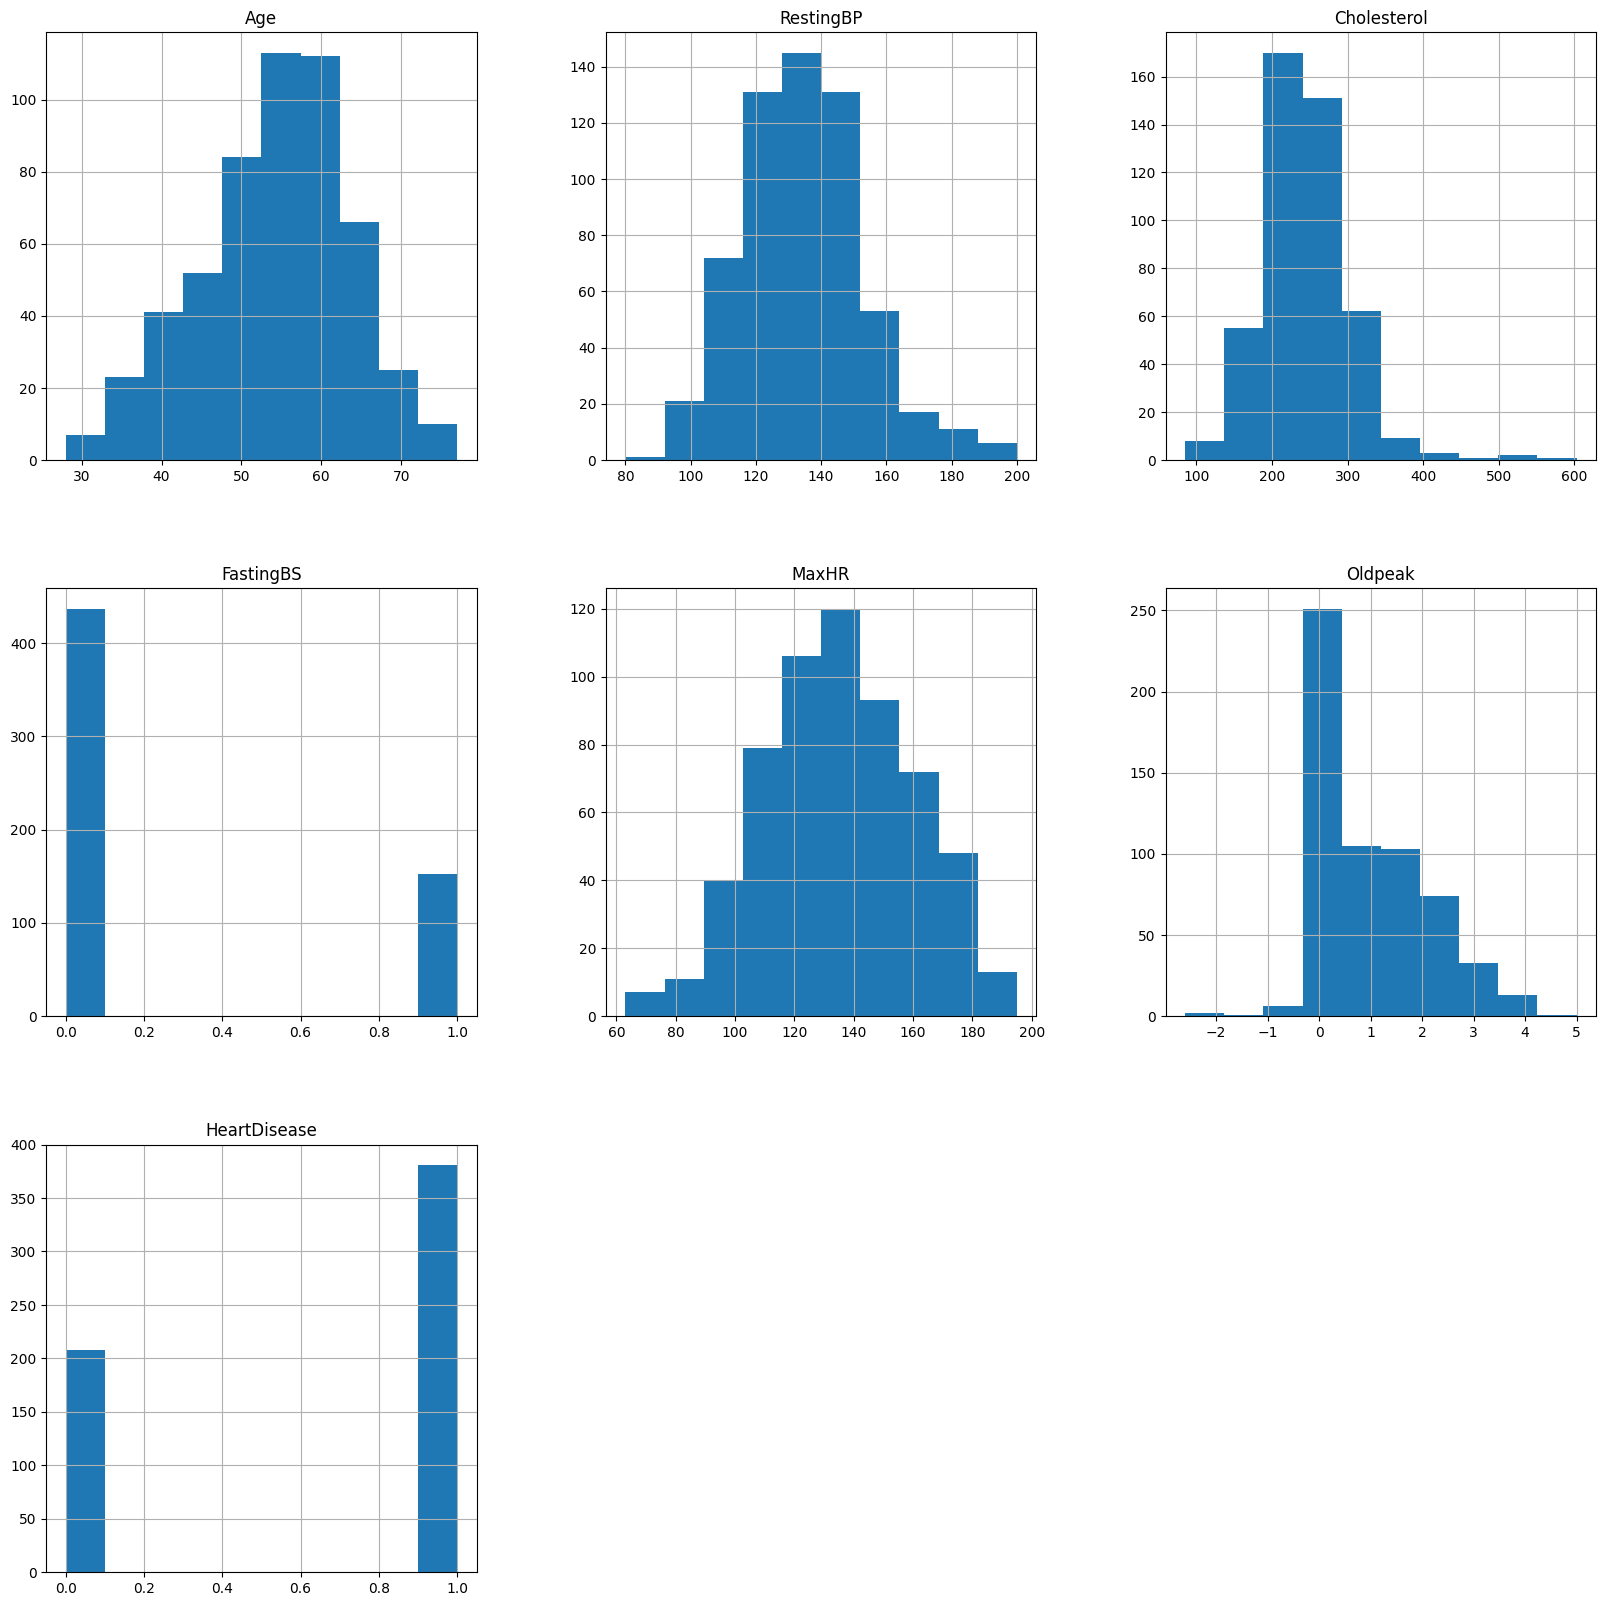

In [6]:
# Гистограммы для численных переменных
df_train.hist(figsize=(20, 20))

In [7]:
# Стобчатые диаграммы для категориальных переменных
def bar_plot(df_column): 
    display(df_column.value_counts(normalize=True))
    counts = df_column.value_counts()
    plt.figure(figsize=(5, 5), facecolor='#f0f0f0')
    plt.bar(counts.index, counts.values, color = 'green')
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.show()

Sex
M   0.810
F   0.190
Name: proportion, dtype: float64

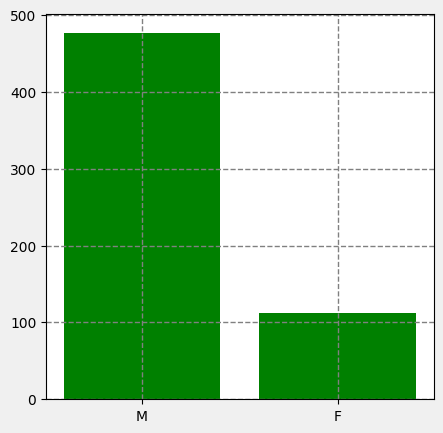

a


ChestPainType
ASY   0.591
NAP   0.199
ATA   0.163
TA    0.048
Name: proportion, dtype: float64

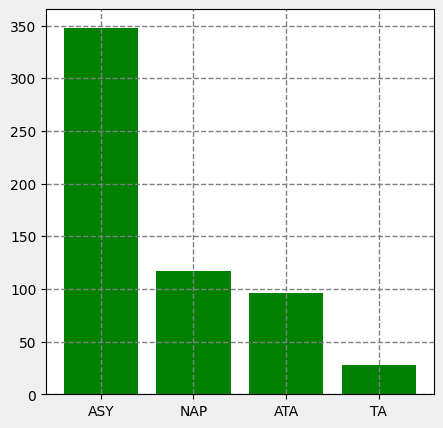

a


RestingECG
Normal   0.586
LVH      0.214
ST       0.200
Name: proportion, dtype: float64

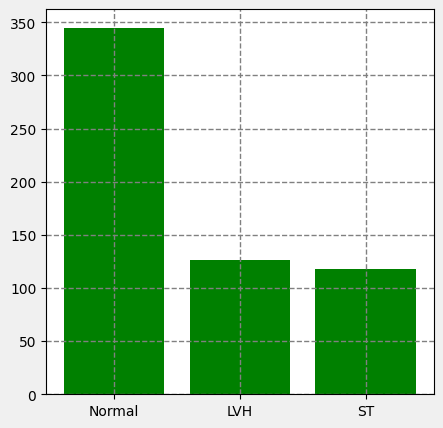

a


ExerciseAngina
N   0.552
Y   0.448
Name: proportion, dtype: float64

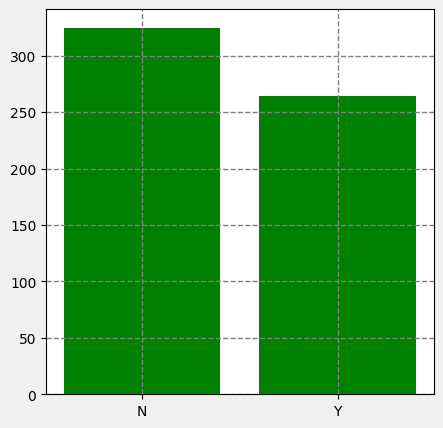

a


ST_Slope
Flat   0.552
Up     0.380
Down   0.068
Name: proportion, dtype: float64

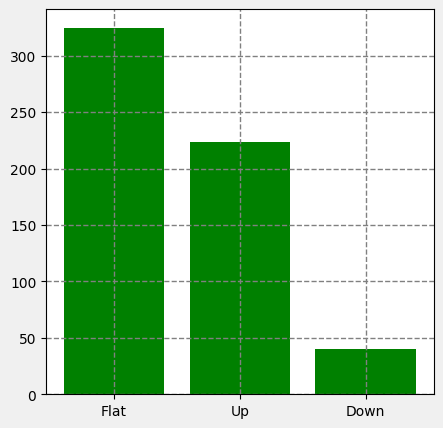

a


In [8]:
for column in df_train.columns:
    if df_train[column].dtype == 'object':
        bar_plot(df_train[column])
        print('a')

Анализ численных переменных:

1. Распределение по возрасту близко к нормальному с параметрами 54,2 +- 9,5;
2. Среднее значение верхнего артериального давления 133,3, медианное 130, что является верхней границей нормы;
3. По параметру Oldpeak видно сильное смещение в сторону положительных значений:

'
Положительное значение oldpeak может указывать на наличие ишемии миокарда, что может быть признаком коронарной болезни сердца.
'

4. По параметру MaxHR (сердцебиение) наблюдается небольшой сдвиг в торонуб значений, больших среднего.
5. По таргету наблюдается дисбаланс в сторону целевого класса:	

HeartDisease [train]
1    0.646859
0    0.353141

В тестовом датасете распределение аналогичное

HeartDisease [test]
1    0.64467
0    0.35533


Анализ категориальных переменных:

1. Наблюдается дисбаланс по классу 'Sex', 81% мужчин и 19% женщин в тренировочном датасете.
В тестовом датасете распределение аналогичное.

Построим график phik-корреляции, чтобы понять, с какими фичами сильнее всего коррелирует таргет.

interval columns not set, guessing: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']


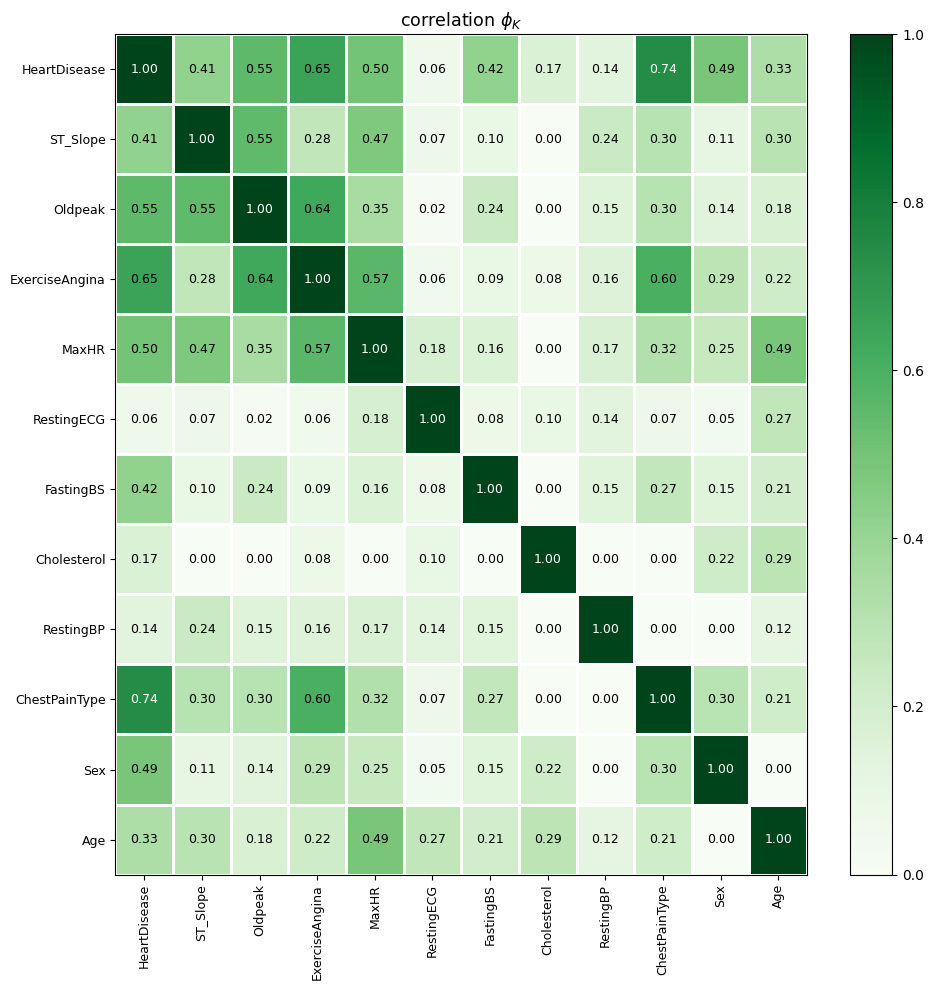

In [9]:
phik_overview = df_train.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map   ="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.9, figsize=(10, 10))
plt.tight_layout()

У целевой переменной наблюдается:

1. Высокая корреляция с переменными 'ChestPainType' 0.74;
2. Заметная корреляция с переменными 'ExerciseAngina' 0.65, 'Oldpeak' 0.55, 'MaxHR' 0.5;
3. Умеренная корреляция с переменными 'ST_Slope' 0.41, 'FastingBS' 0.42,  'Age' 0.33;
4. Слабая корреляция с остальными переменными;

Посмотрим на парные графики таргета с переменными 'ChestPainType', 'ExerciseAngina', 'Oldpeak' , 'MaxHR'.

In [10]:
def num_pairplot(x, y, xlabel: str, ylabel:str):
    
    plt.figure(figsize=(10, 5), facecolor='#f0f0f0')
    plt.scatter(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.show()

def cat_pairplot(df, xlabel: str):
    sns.countplot(data=df[[xlabel, 'HeartDisease']], x=xlabel, hue='HeartDisease')
    plt.title(f'Pairplot of {xlabel} and HeartDisease')
    plt.xlabel(xlabel)
    plt.ylabel('Observations')
    plt.legend(title='HeartDisease')
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.show()


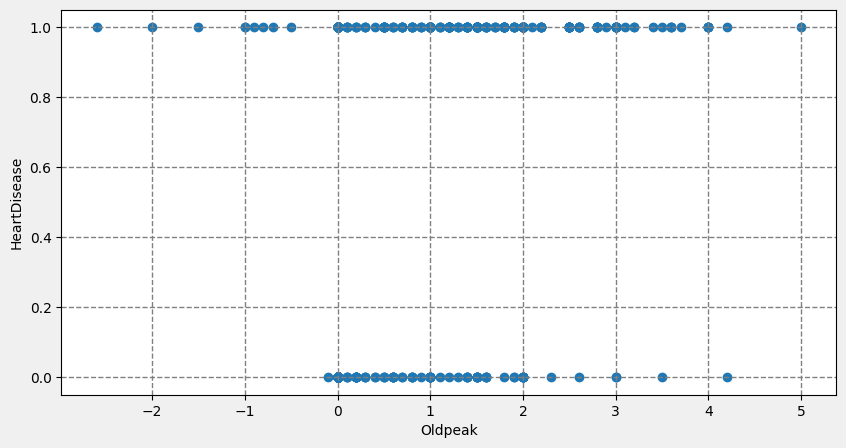

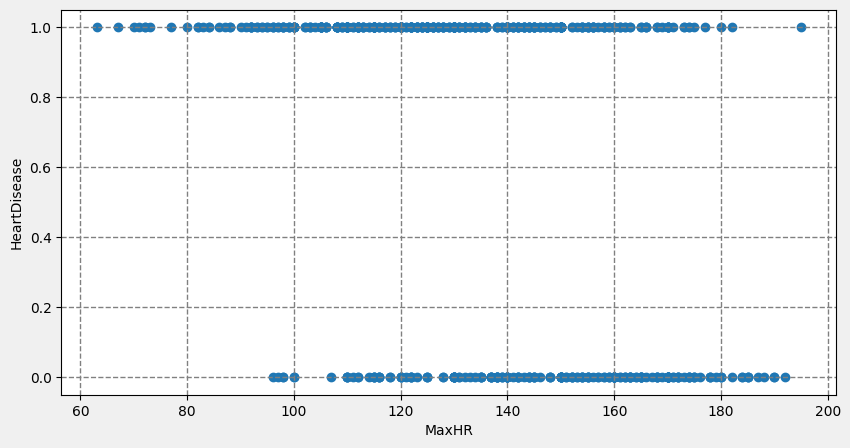

In [11]:
lst_high_corr = ['ChestPainType', 'ExerciseAngina', 'Oldpeak' , 'MaxHR']

num_pairplot(x = df_train['Oldpeak'], y = df_train['HeartDisease'], xlabel = 'Oldpeak', ylabel= 'HeartDisease')
num_pairplot(x = df_train['MaxHR'], y = df_train['HeartDisease'], xlabel = 'MaxHR', ylabel= 'HeartDisease')

Из этих графиков можно сделать два важных вывода:

1. У здоровых людей практически не бывает отрицательного OldPeak;
2. У здоровых людей выше среднее значение MaxHR и его показатель практически всегда > 100.

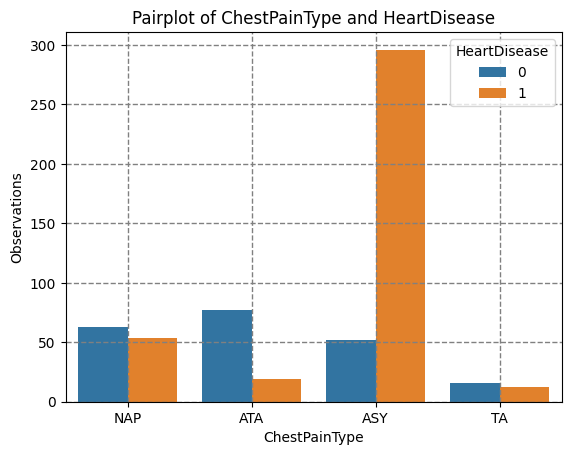

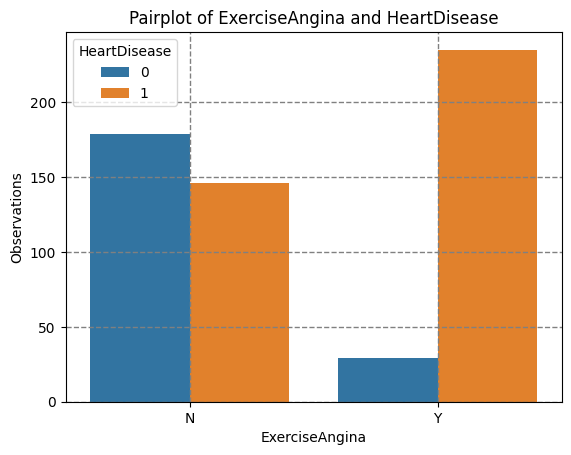

In [12]:
cat_pairplot(df_train, 'ChestPainType')
cat_pairplot(df_train, 'ExerciseAngina')

Из этих графиков можно сделать 2 важных вывода:

1. Среди людей с ChestPainType = 'ATA' преобладают здоровые:

HeartDisease
0    0.802083
1    0.197917

Среди людей с ChestPainType = 'ASY' преобладают больные:

HeartDisease
1    0.850575
0    0.149425

2. Среди людей с True параметром ExerciseAngina преобладают больные:

HeartDisease
1    0.890152
0    0.109848

In [13]:
print('ChestPainType = "ATA"')
display(df_train[df_train['ChestPainType'] == 'ATA']['HeartDisease'].value_counts(normalize=True))

print('ChestPainType = "ASY"')
display(df_train[df_train['ChestPainType'] == 'ASY']['HeartDisease'].value_counts(normalize=True))

print('ExerciseAngina = "Y"')
display(df_train[df_train['ExerciseAngina'] == 'Y']['HeartDisease'].value_counts(normalize=True))

ChestPainType = "ATA"


HeartDisease
0   0.802
1   0.198
Name: proportion, dtype: float64

ChestPainType = "ASY"


HeartDisease
1   0.851
0   0.149
Name: proportion, dtype: float64

ExerciseAngina = "Y"


HeartDisease
1   0.890
0   0.110
Name: proportion, dtype: float64

Обучение моделей.

Мы обучим три модели и сравним их метрики:

1. Логистическая регрессия;
2. Случайный лес (анализ данных показывает, что есть несколько фич, неплохо разделяющих целевой класс);
3. Градиентный бустинг с catboost.

После этого мы будем принимать решение, какую из моделей оборачивать в пайплайн, сериализовать и отправлять на развёртку.
Начнём с catboost.

In [14]:
# Фиксируем seed
SEED = 1

In [15]:
# Отделяем категориальные переменные
cat_features = []

for column in df_train.columns:
    if df_train[column].dtype == 'object':
        cat_features.append(column)

for feature in cat_features:
    df_train[feature] = df_train[feature].astype(str)

In [16]:
# Отделяем таргет от фичей

features_train_cb = df_train.drop('HeartDisease', axis = 1)
target_train_cb = df_train['HeartDisease']

features_test_cb = df_test.drop('HeartDisease', axis = 1)
target_test_cb = df_test['HeartDisease']

In [17]:
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'verbose': 200,
    'random_seed': SEED,
    'cat_features': cat_features}

cbc_1 = CatBoostClassifier(**params)
cbc_1.fit(features_train_cb, target_train_cb, 
          eval_set = (features_test_cb, target_test_cb), 
          use_best_model = True, 
          plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.027805
0:	test: 0.8825084	best: 0.8825084 (0)	total: 76.9ms	remaining: 1m 16s
200:	test: 0.9224972	best: 0.9227222 (193)	total: 983ms	remaining: 3.9s
400:	test: 0.9213723	best: 0.9227222 (193)	total: 1.81s	remaining: 2.71s
600:	test: 0.9181102	best: 0.9227222 (193)	total: 2.73s	remaining: 1.81s
800:	test: 0.9173228	best: 0.9227222 (193)	total: 3.67s	remaining: 912ms
999:	test: 0.9143982	best: 0.9227222 (193)	total: 4.66s	remaining: 0us

bestTest = 0.9227221597
bestIteration = 193

Shrink model to first 194 iterations.


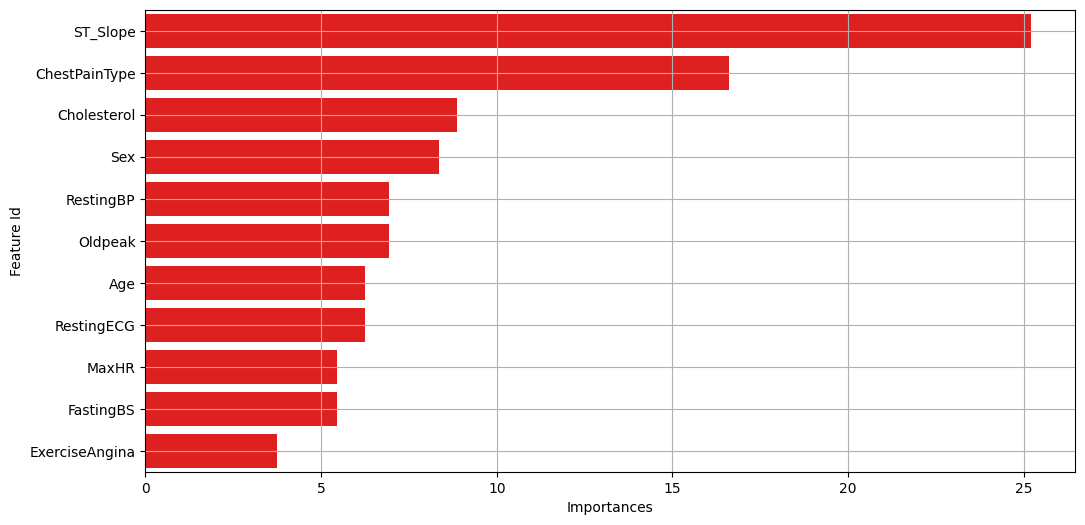

In [18]:
# Посмотрим на важность фич

plt.figure(figsize=(12, 6))
sns.barplot(data = cbc_1.get_feature_importance(prettified=True), x = 'Importances', y = 'Feature Id', color='red')
plt.grid()
plt.show()

AUC на лучшей итерации равен 0.923;
посмотрим, какой результат покажет кросс-валидация на тренировочном датасете.

In [19]:
# Посмотрим, что покажет кросс-валидация

params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'verbose': 200,
    'random_seed': SEED,
    'cat_features': cat_features
}

train_data = Pool(data=features_train_cb, label=target_train_cb, cat_features=cat_features)

N_folds = 4

scores = catboost.cv(pool=train_data,
            params=params, 
            fold_count=N_folds,
            seed=SEED, 
            shuffle=True,
            stratified=True,
            plot=True,
            return_models = True
           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/4]
0:	test: 0.9036458	best: 0.9036458 (0)	total: 24.7ms	remaining: 24.7s
200:	test: 0.9421074	best: 0.9427083 (195)	total: 1.26s	remaining: 5.01s
400:	test: 0.9429087	best: 0.9437099 (294)	total: 3.05s	remaining: 4.55s
600:	test: 0.9443109	best: 0.9453125 (572)	total: 4.55s	remaining: 3.02s
800:	test: 0.9441106	best: 0.9453125 (572)	total: 5.96s	remaining: 1.48s
999:	test: 0.9457131	best: 0.9459135 (833)	total: 8.11s	remaining: 0us

bestTest = 0.9459134615
bestIteration = 833

Training on fold [1/4]
0:	test: 0.8411943	best: 0.8411943 (0)	total: 51.7ms	remaining: 51.6s
200:	test: 0.9273279	best: 0.9285425 (186)	total: 1.83s	remaining: 7.27s
400:	test: 0.9255061	best: 0.9285425 (186)	total: 3.31s	remaining: 4.94s
600:	test: 0.9244939	best: 0.9285425 (186)	total: 4.25s	remaining: 2.82s
800:	test: 0.9240891	best: 0.9285425 (186)	total: 5.37s	remaining: 1.33s
999:	test: 0.9238866	best: 0.9285425 (186)	total: 6.54s	remaining: 0us

bestTest = 0.9285425101
bestIteration = 1

In [20]:
scores[0][scores[0]['test-AUC-mean'] == scores[0]['test-AUC-mean'].max()]

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
113,113,0.939,0.012,0.291,0.027,0.176,0.010


Среднее значение auc на кросс-валидации равно 0,939;
усредним теперь лучшие модели кросс-валидации и посмотрим на их предсказание на тестовой выборке.

In [21]:
test_proba = np.zeros(target_test_cb.shape[0])

for i in range(N_folds):
    test_proba += scores[1][i].predict(features_test_cb, prediction_type = 'Probability')[:, 1]

test_proba /= N_folds

print(f'Метрика auc на тестовой выборке: {roc_auc_score(target_test_cb, test_proba):.3f}')

Метрика auc на тестовой выборке: 0.922


In [22]:
def show_metrics(y_true, y_pred, name_of_model: str):
    result = dict()
    result['model'] = name_of_model

    metrics = [accuracy_score, precision_score, recall_score, f1_score]
    names = ['accuracy', 'precision', 'recall', 'f1_score']

    for i in range(4):
        result[names[i]] = metrics[i](y_true, y_pred)

    return pd.DataFrame([result])
    

In [23]:
# Неплохой результат по recall и f1-score

y_pred = [1 if element > 0.5 else 0 for element in test_proba]

show_metrics(target_test_cb, y_pred, 'catboost')

,model,accuracy,precision,recall,f1_score
0,catboost,0.863,0.857,0.945,0.899


Случайный лес и логистическая регрессия

In [24]:
# Предобработка данных

def fill_with_median(df, columns: list):
    for column in columns:
        df[column] = df[column].fillna(df[column].median())

fill_with_median(df_train, ['Cholesterol', 'Age', 'RestingBP'])
fill_with_median(df_test, ['Cholesterol', 'Age'])

In [25]:
# Кодирование категориальных переменных

df_train = 1*pd.get_dummies(df_train, drop_first=True)
df_test = 1*pd.get_dummies(df_test, drop_first=True)

In [26]:
# Отделение фичи от таргета

features_train = df_train.drop('HeartDisease', axis = 1)
target_train = df_train['HeartDisease']

features_test = df_test.drop('HeartDisease', axis = 1)
target_test = df_test['HeartDisease']

In [27]:
# Предобработка
scaler = StandardScaler()
features_train_sc = scaler.fit_transform(features_train)
features_test_sc = scaler.transform(features_test)

In [28]:
# Обучение случайного леса

forest = RandomForestClassifier(random_state=SEED)
forest.fit(features_train_sc, target_train)
y_forest_prob = forest.predict_proba(features_test_sc)[:, 1]
y_forest_pred = forest.predict(features_test_sc)

In [29]:
# Метрики случайного леса

print(f'AUC случайного леса на тестовой выборке {roc_auc_score(target_test, y_forest_prob):.3f}')
show_metrics(target_test, y_forest_pred, 'random_forest')

AUC случайного леса на тестовой выборке 0.912


,model,accuracy,precision,recall,f1_score
0,random_forest,0.863,0.873,0.921,0.897


In [30]:
# Обучение логистической регресии
log_reg = LogisticRegression(random_state=SEED)
log_reg.fit(features_train_sc, target_train)

y_log_prob = log_reg.predict_proba(features_test_sc)[:, 1]
y_log_pred = log_reg.predict(features_test_sc)

print(f'AUC логистической регрессии на тестовой выборке {roc_auc_score(target_test, y_log_prob):.3f}')
show_metrics(target_test, y_log_pred, 'logistic_regression')


AUC логистической регрессии на тестовой выборке 0.902


,model,accuracy,precision,recall,f1_score
0,logistic_regression,0.878,0.887,0.929,0.908


In [31]:
# Соберём все результаты в единый Dataframe

pd.concat([show_metrics(target_test, y_log_pred, 'logistic_regression'),
           show_metrics(target_test, y_forest_pred, 'random_forest'),
           show_metrics(target_test_cb, y_pred, 'catboost')], ignore_index=True)

,model,accuracy,precision,recall,f1_score
0,logistic_regression,0.878,0.887,0.929,0.908
1,random_forest,0.863,0.873,0.921,0.897
2,catboost,0.863,0.857,0.945,0.899


In [32]:
auc_results = {
    'logistic_regression': 0.902,
    'random_forest': 0.913,
    'catboost': 0.923
}

Лучшей моделью по auc оказался CatBoostClassifier с результатом 0,923. Обученная модель хранится в переменной cbc_1.
Поскольку catboost не требует дополнительной предобработки данных, строить для него pipeline в том формате, какой был на уроках не очень осмысленно.

Вместо этого попробуем решить следующую задачу -- обучим логистическую регрессию, которая на тестовых данных за счёт изменения threshold покажет лучший результат по accuracy (предположим, что нам поставили такую задачу).

Предварительно разделим тренировочные данные на тренировочную и валидационную часть (на валидационной части мы будем тестировать оптимальное значение threshold).

In [33]:
# Разделим тренировочные данные на тренировочную и валидационную часть

features_train_1, features_val, target_train_1, target_val = train_test_split(features_train, 
                                                                              target_train, 
                                                                              test_size=0.25, 
                                                                              random_state=SEED,
                                                                              shuffle=True,
                                                                              stratify=target_train)

In [34]:
scaler_1 = StandardScaler()

features_train_1_sc = scaler_1.fit_transform(features_train_1)
features_val_sc = scaler_1.transform(features_val)
features_test_1_sc = scaler_1.transform(features_test)

In [35]:
model = LogisticRegressionCV(random_state=SEED)
model.fit(features_train_1_sc, target_train_1)

y_model_prob = model.predict_proba(features_val_sc)[:, 1]

In [36]:
lst_of_acc = np.zeros(101)

for i in range(101):
    threshold = i/100
    y_pred = [1 if element > threshold else 0 for element in y_model_prob]
    lst_of_acc[i] = accuracy_score(target_val, y_pred)

np.argmax(lst_of_acc)

47

In [37]:
# Проверим результат на тесте

y_test_pred = [1 if element > 0.47 else 0 for element in model.predict_proba(features_test_1_sc)[:, 1]]
print(accuracy_score(target_test, y_test_pred))

0.8730964467005076


Особых успехов это нам не принесло. Попробуем теперь поискать лучшую логистическую регрессию с помощью GridSearch (максимизируя accuracy), обернув её в pipeline.

In [38]:
class HeartDiaseses(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for column in X.columns:
            if X[column].dtype != 'object':
                X[column] = X[column].fillna(X[column].median())
        
        X = 1*pd.get_dummies(X, drop_first=True)

        return X

In [39]:
# Загрузка и разделение данных (без предобработки)

df_train = pd.read_csv('heart_adapt_train.csv')
df_test = pd.read_csv('heart_adapt_test.csv')

features_train = df_train.drop('HeartDisease', axis = 1)
target_train = df_train['HeartDisease']

features_test = df_test.drop('HeartDisease', axis = 1)
target_test = df_test['HeartDisease']

In [40]:
pipe = Pipeline([  
  ('preprocessing', HeartDiaseses()),
  ('scaler', StandardScaler()),
  ('classify', LogisticRegression(random_state=SEED))
])

params = [
    {'classify': [LogisticRegression(random_state=SEED)], 
     'classify__solver': ['liblinear', 'newton-cholesky', 'newton-cg', 'sag', 'sag'],
     'classify__max_iter': [100, 150, 200, 250, 300, 350]
     }
]

grid_search = GridSearchCV(pipe, param_grid=params, cv=5, scoring='accuracy')

grid_search.fit(X=features_train, y=target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', HeartDiaseses()),
                                       ('scaler', StandardScaler()),
                                       ('classify',
                                        LogisticRegression(random_state=1))]),
             param_grid=[{'classify': [LogisticRegression(random_state=1)],
                          'classify__max_iter': [100, 150, 200, 250, 300, 350],
                          'classify__solver': ['liblinear', 'newton-cholesky',
                                               'newton-cg', 'sag', 'sag']}],
             scoring='accuracy')

In [41]:
show_metrics(target_test, grid_search.predict(features_test), 'grid_search_log_reg')

,model,accuracy,precision,recall,f1_score
0,grid_search_log_reg,0.878,0.887,0.929,0.908


In [42]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing', HeartDiaseses()),
                ('scaler', StandardScaler()),
                ('classify',
                 LogisticRegression(random_state=1, solver='liblinear'))])

In [43]:
with open('best_auc_catboost.pk', 'wb') as file:
    pickle.dump(cbc_1, file)

with open('best_accuracy_log_reg.pk', 'wb') as file:
    pickle.dump(grid_search, file)